In [1]:
%vertica SELECT 'Connected to Vertica!'

,?column?
0,Connected to Vertica!


In [2]:
import matplotlib.pyplot as plt
from plotnine import *
from edx_stats import grouped_confidence_intervals
from edx_plot import geom_confidence, theme_confidence

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Experiment 6: Recurring Generic Nudges

We started this experiment on Monday 2017-07-10. On that date we ran a query to identify a group of learners whose content availability date was within the past 7 days in self-paced courses. For learners who met those criteria in multiple courses we used the enrollment with the earliest content availability date. Once we had selected all of the enrollments to include in the experiment (exactly one per edX learner), we randomly assigned them into a treatment group or a control group.

The treatment group was then sent a "nudge" email that included some basic personalization, but was largely generic. It included the learner's name and the name of the course. The rest was an encouraging message designed to drive them back into the course. However, the message was not course-specific.

Note that the first email was sent around 2 PM EDT, however, for the purposes of this analysis we count all activity in that first day.

In [3]:
import datetime
from dateutil.tz import gettz, tzutc

earliest_enrollment_time = datetime.datetime(2017, 7, 4, 0, 0, tzinfo=tzutc())
experiment_start_time = datetime.datetime(2017, 7, 10, 14, tzinfo=gettz('America/New_York'))
intervention_date = experiment_start_time.date()
experiment_id = 6

In [4]:
%%vertica
SET TIME ZONE TO UTC

# Look at email stats

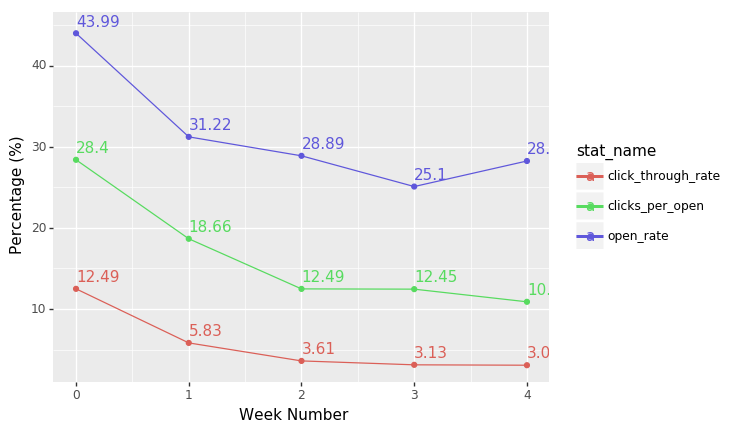

<ggplot: (8734083875318)>

,stat_name,value,week_num
0,open_rate,0.439928,0
1,click_through_rate,0.124926,0
2,opt_out_rate,0.001396,0
3,clicks_per_open,0.283969,0
4,sent,33676.000000,0
5,open_rate,0.312241,1
6,click_through_rate,0.058273,1
7,opt_out_rate,0.001421,1
8,clicks_per_open,0.186628,1
9,sent,32382.000000,1


In [5]:
import edx_sailthru

edx_sailthru.get_weekly_stats(
    template='RET Recurring Nudge',
    start_date=experiment_start_time.date(),
    num_weeks=5
)

### Analysis Note

production.f_user_activity contains aggregated engagement data for each (user, course, date) tuple. However, it is only updated once per week. It includes all data up to (but not including) each Monday at 00:00 UTC.

We want to only include complete 7-day weeks in our analysis. In this particular case that works out since our emails are sent out on Mondays, however, for other analyses some care needs to be taken to make sure the analysis doesn't contain partial weeks of data.

In [6]:
%%vertica (intervention_date, experiment_id) -> engagement

-- This should return one record per enrollment per week
SELECT
    ee.user_id,
    ee.course_id,
    ee.group_name,
    week_num.weeks_since_experiment_start,
    cnt_days_in_week,
    COALESCE(act.is_engaged, 0) AS is_engaged,
    COALESCE(act.cnt_engaged_activity, 0) AS cnt_engaged_activity
FROM
(
    -- For this experiment, this is unneccessary since we chose a single enrollment per user and each enrollment
    -- was assigned to exactly one group. However, if this code is copy-pasted we want to make sure that
    -- exactly one record per enrollment is returned from this sub-query and that enrollment was assigned to exactly
    -- one group.
    SELECT
        user_id,
        course_id,
        MAX(group_name) AS group_name
    FROM
        ret.email_experiment
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT group_name) = 1
) ee

JOIN
(
    -- This table simply returns one row with one integer for each week after the start of the experiment that
    -- represents the number of weeks that have elapsed since the start of the experiment. This will look something
    -- like:
    --    weeks_since_experiment_start
    --    0
    --    1
    --    2
    SELECT
        FLOOR(DATEDIFF('day', :intervention_date, date) / 7) AS weeks_since_experiment_start,
        COUNT(DISTINCT date) AS cnt_days_in_week
    FROM business_intelligence.calendar
    WHERE
        date BETWEEN :intervention_date AND (SELECT MAX(date) FROM production.f_user_activity)
    GROUP BY 1
    -- Only include complete weeks
    HAVING COUNT(DISTINCT date) = 7

-- This join condition will ensure that we get one full copy of our enrollments per week. The first copy will
-- have week_num.weeks_since_experiment_start == 0, the second 1, the third 2 etc.
) AS week_num ON 1=1

-- There is a problem with the BI table that defines engagement, so we go directly to the f_user_activity table.
-- We are careful here to define engagement in the standard way.
LEFT JOIN
(
    SELECT
        user_id,
        course_id,
        FLOOR(DATEDIFF('day', :intervention_date, date) / 7) AS weeks_since_experiment_start,
        CASE WHEN SUM(number_of_activities) > 0 THEN 1 ELSE 0 END AS is_engaged,
        SUM(number_of_activities) AS cnt_engaged_activity
    FROM
        production.f_user_activity
    WHERE
        date >= :intervention_date
        AND activity_type IN ('PLAYED_VIDEO', 'POSTED_FORUM', 'ATTEMPTED_PROBLEM')
    GROUP BY 1, 2, 3
) as act
    ON act.user_id = ee.user_id
    AND act.course_id = ee.course_id
    AND act.weeks_since_experiment_start = week_num.weeks_since_experiment_start

In [7]:
assert len(engagement[engagement.cnt_days_in_week != 7]) == 0, 'Every week should have 7 days in it.'

Inpsect the frame to ensure we have one record per enrollment per week. The number in each group (Control and Treatment) should be the same every week.

In [8]:
engagement.groupby(['weeks_since_experiment_start', 'group_name']).user_id.count()

weeks_since_experiment_start  group_name
0                             Control       34418
                              Treatment     34398
1                             Control       34418
                              Treatment     34398
2                             Control       34418
                              Treatment     34398
3                             Control       34418
                              Treatment     34398
4                             Control       34418
                              Treatment     34398
5                             Control       34418
                              Treatment     34398
Name: user_id, dtype: int64

In [9]:
engagement.groupby(['weeks_since_experiment_start', 'group_name', 'is_engaged']).user_id.count()

weeks_since_experiment_start  group_name  is_engaged
0                             Control     0             30810
                                          1              3608
                              Treatment   0             29649
                                          1              4749
1                             Control     0             32189
                                          1              2229
                              Treatment   0             31739
                                          1              2659
2                             Control     0             32863
                                          1              1555
                              Treatment   0             32646
                                          1              1752
3                             Control     0             33281
                                          1              1137
                              Treatment   0             32929
                 

# Look at the overall engagement trend over time

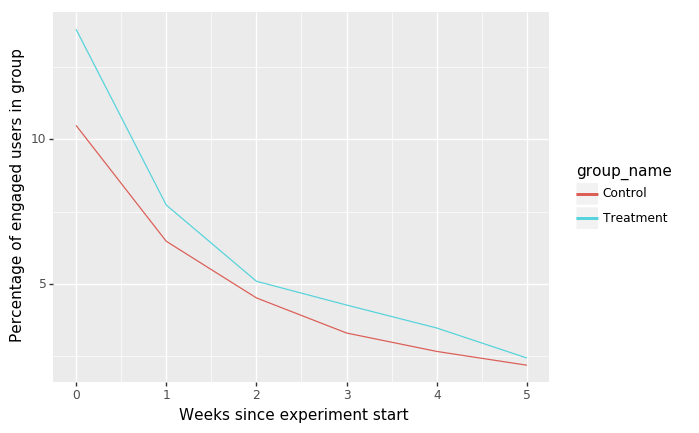

<ggplot: (8734083826366)>

In [10]:
import pandas as pd
from plotnine import *
from IPython.display import display

users_per_group = engagement[engagement.weeks_since_experiment_start == 0].groupby(['group_name']).user_id.count()

data = []
for key, group in engagement.groupby(['weeks_since_experiment_start', 'group_name', 'is_engaged']):
    weeks_since_experiment_start, group_name, is_engaged = key
    cnt_users_in_group = int(users_per_group[group_name])
    cnt_users = len(group)
    data.append(
        {
            'weeks_since_experiment_start': int(weeks_since_experiment_start),
            'group_name': group_name,
            'is_engaged': bool(is_engaged),
            'cnt_users': cnt_users,
            'cnt_users_in_group': cnt_users_in_group,
            'ratio': float(cnt_users) / cnt_users_in_group,
        }
    )

engaged_over_time = pd.DataFrame(data)

display(
    ggplot(
        engaged_over_time[engaged_over_time.is_engaged],
        aes(
            x='weeks_since_experiment_start',
            y='ratio * 100',
            color='group_name'
        )
    )
    + geom_line()
    + xlab('Weeks since experiment start')
    + ylab('Percentage of engaged users in group')
)

In [11]:
import edx_stats
import edx_plot
from plotnine import *
from IPython.display import display

def compute_confidence_interval(df, variant_col, value_col, title, group_by=None):
    conf_intervals = edx_stats.grouped_confidence_intervals(
        df.reset_index(),
        variant_col=variant_col,
        value_col=value_col,
        ctrl_name='Control',
        group_cols=[group_by] if group_by else []
    )
    plot = (
        ggplot(conf_intervals.reset_index(), aes(
            x=group_by or variant_col,
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5,
        ))
        + edx_plot.geom_confidence()
        + edx_plot.theme_confidence()
        + ggtitle(title)
    )
    if group_by:
        plot += facet_grid(". ~ " + variant_col)
    display(plot)
    return conf_intervals

## Change in number of users who return and engage with the course

/app/lib/edx_stats.py:124: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


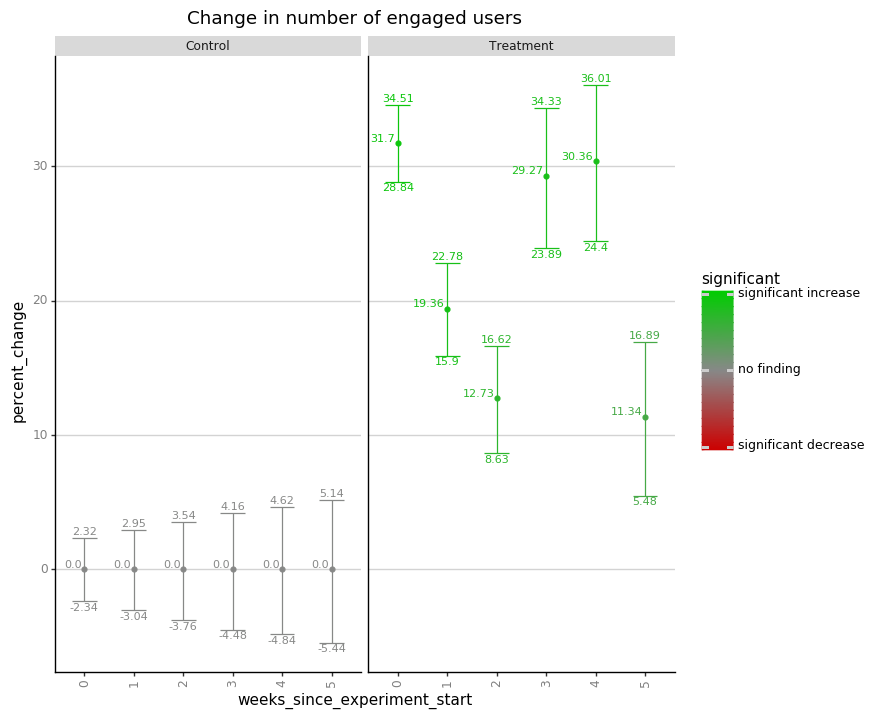

<ggplot: (-9223363302773117496)>

lower_bound  percent_change  \
weeks_since_experiment_start group_name                                
0                            Control       -2.343815        0.000000   
                             Treatment     28.842102       31.700699   
1                            Control       -3.036298        0.000000   
                             Treatment     15.897513       19.360521   
2                            Control       -3.759894        0.000000   
                             Treatment      8.633415       12.734319   
3                            Control       -4.479173        0.000000   
                             Treatment     23.889131       29.274769   
4                            Control       -4.835165        0.000000   
                             Treatment     24.403176       30.358975   
5                            Control       -5.444240        0.000000   
                             Treatment      5.480641       11.337907   

                                         upper_bound  significant  
weeks_since_experiment_start group_name                            
0                            Control        2.320011     0.000000  
                             Treatment     34.505591     0.909825  
1                            Control        2.953283     0.000000  
                             Treatment     22.784722     0.821130  
2                            Control        3.539985     0.000000  
                             Treatment     16.623338     0.677964  
3                            Control        4.163595     0.000000  
                             Treatment     34.333393     0.816031  
4                            Control        4.621849     0.000000  
                             Treatment     36.009536     0.803821  
5                            Control        5.142084     0.000000  
                             Treatment     16.892628     0.483391

In [12]:
compute_confidence_interval(
    engagement,
    variant_col='group_name',
    value_col='is_engaged',
    title='Change in number of engaged users',
    group_by='weeks_since_experiment_start'
)

TODO: Segment by week-1 engagement level

# Bookings and VTR

Figure out how recent the data is in the finance table. Round down to only look at transactions before midnight on the last day.

In [13]:
%%vertica -> last_transaction_date_df
SELECT
    MAX(order_timestamp)::DATE AS last_transaction_date
FROM
    finance.f_orderitem_transactions f
WHERE
    f.transaction_type IS NOT NULL
    AND f.order_username IS NOT NULL
    AND f.partner_short_code = 'edx'

In [14]:
from dateutil.tz import tzutc

last_transaction_date = last_transaction_date_df.loc[0][0]
transaction_cutoff = datetime.datetime(
    last_transaction_date.year, last_transaction_date.month, last_transaction_date.day, 0, tzinfo=tzutc()
)
transaction_cutoff

datetime.datetime(2017, 8, 22, 0, 0, tzinfo=tzutc())

In [15]:
%%vertica (experiment_start_time, transaction_cutoff, experiment_id) -> conversions

-- This query should return one record per enrollment.
SELECT
    emailed.user_id,
    emailed.course_id,
    emailed.group_name AS variation_name,
    course.pacing_type,
    purchased.purchase_time,
    CASE WHEN purchased.purchase_time IS NOT NULL THEN 1 ELSE 0 END AS 'verified',
    COALESCE(purchased.gross_bookings, 0)::FLOAT AS gross_bookings
FROM

(
    SELECT
        user_id,
        course_id,
        username,
        MAX(group_name) AS group_name
    FROM
        ret.email_experiment
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2, 3
    HAVING COUNT(DISTINCT group_name) = 1
) emailed

-- Need to join with d_course to get the pacing_type for the course
JOIN production.d_course course ON course.course_id = emailed.course_id

-- Now join with our finance table to find all sales and refunds for this user that are *after* the first exposure
LEFT JOIN
(
    -- This gathers all transactions associated with an enrollment and pins them to the first transaction time.
    -- This should return one record per enrollment.
    SELECT
        f.order_username AS username,
        f.order_course_id AS course_id,
        MIN(f.order_timestamp)::TIMESTAMPTZ AS purchase_time,
        SUM(CASE WHEN f.transaction_type = 'sale' THEN f.transaction_amount_per_item ELSE 0 END) AS gross_bookings
    FROM
        finance.f_orderitem_transactions f
    WHERE
        f.transaction_type IS NOT NULL
        AND f.order_username IS NOT NULL
        AND f.partner_short_code = 'edx'
    GROUP BY
        1, 2
) AS purchased
    ON  emailed.username = purchased.username
    AND emailed.course_id = purchased.course_id
WHERE
       purchased.purchase_time IS NULL
    OR purchased.purchase_time BETWEEN :experiment_start_time AND :transaction_cutoff

In [16]:
a = conversions.groupby(['user_id', 'course_id']).size()
assert len(a[a > 1]) == 0, 'There should be exactly one record per enrollment'

In [17]:
totals = conversions.groupby('variation_name').verified.count()
converted = conversions.groupby('variation_name').verified.sum()

print(totals)
print(converted)
converted / totals

variation_name
Control      34107
Treatment    34095
Name: verified, dtype: int64
variation_name
Control      139
Treatment    140
Name: verified, dtype: int64


variation_name
Control      0.004075
Treatment    0.004106
Name: verified, dtype: float64

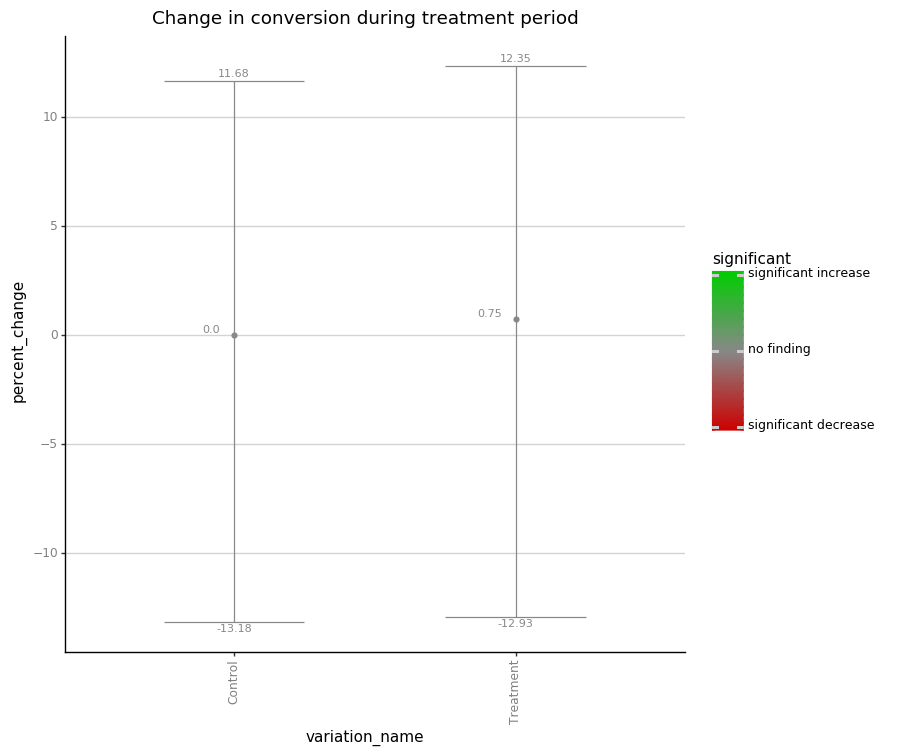

<ggplot: (8734083810852)>

,lower_bound,percent_change,upper_bound,significant
variation_name,,,,
Control,-13.178295,0.000000,11.678832,0
Treatment,-12.930517,0.754873,12.347942,0


In [18]:
compute_confidence_interval(
    conversions,
    variant_col='variation_name',
    value_col='verified',
    title='Change in conversion during treatment period'
)

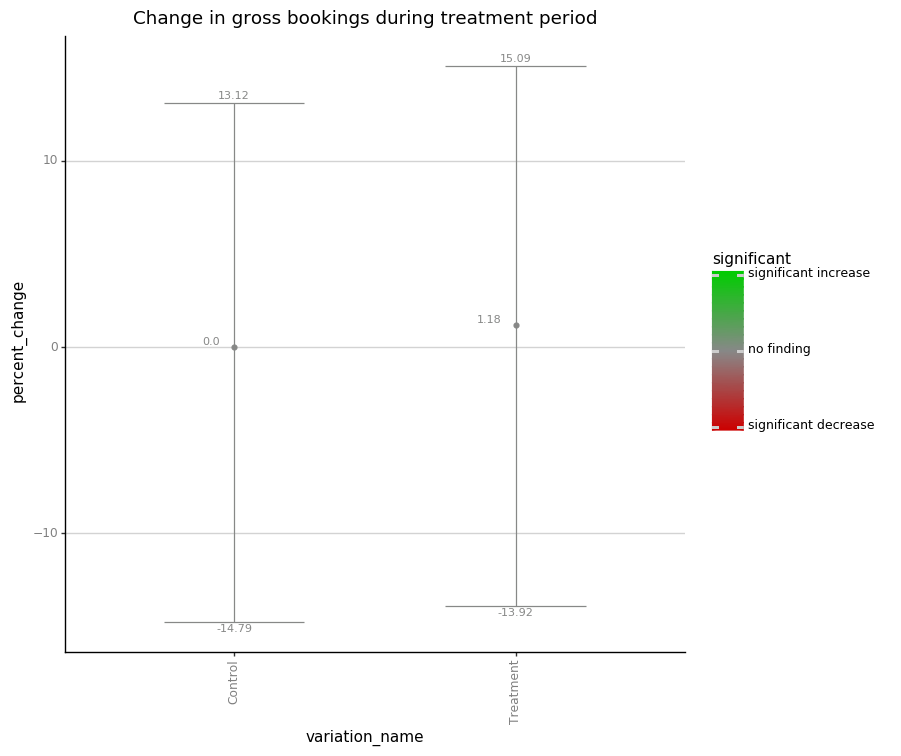

<ggplot: (-9223363302777537876)>

,lower_bound,percent_change,upper_bound,significant
variation_name,,,,
Control,-14.788969,0.000000,13.118905,0
Treatment,-13.921809,1.179953,15.086567,0


In [19]:
compute_confidence_interval(
    conversions,
    variant_col='variation_name',
    value_col='gross_bookings',
    title='Change in gross bookings during treatment period'
)

# Looking at conversion over time

The goal of this analysis is to compare the purchasing behavior over time with other courses that were not included in our experiment.

In [20]:
%%vertica (experiment_start_time, experiment_id, earliest_enrollment_time) -> audit_duration_counts

SELECT
    CASE
        WHEN exp.variation_name IS NOT NULL THEN exp.variation_name
        ELSE 'Not In Experiment'
    END AS variation_name,
    CASE
        WHEN duc.first_verified_enrollment_time IS NULL THEN DATEDIFF('day', duc.first_enrollment_time, NOW())
        ELSE DATEDIFF('day', duc.first_enrollment_time, duc.first_verified_enrollment_time)
    END AS duration,
    duc.first_verified_enrollment_time IS NOT NULL AS verified,
    COUNT(*) AS cnt_users
FROM
    production.d_user_course duc
LEFT JOIN
(
    SELECT
        user_id,
        course_id,
        MAX(group_name) AS variation_name
    FROM
        ret.email_experiment
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT group_name) = 1
) exp ON exp.user_id = duc.user_id AND exp.course_id = duc.course_id
JOIN 
    business_intelligence.course_master AS c ON c.course_id = duc.course_id
WHERE
    -- only include enrollments that occurred before the verification deadline
    duc.first_enrollment_time <= c.course_verification_end_date
    
    -- these are the conditions for courses being included in the experiment
    AND c.pacing_type = 'self_paced'
    AND (c.content_language IS NULL OR c.content_language LIKE 'en%')
    AND c.is_WL = 0
    
    -- compare against a baseline that matches our selection criteria for the experiment: content availability date
    -- within one week from the start of the experiment
    AND GREATEST(duc.first_enrollment_time, c.course_start_date) BETWEEN :earliest_enrollment_time AND :experiment_start_time

    -- only look at verified upgrades after the start of the experiment
    AND (
        duc.first_verified_enrollment_time >= :experiment_start_time
        OR
        duc.first_verified_enrollment_time IS NULL
    )

GROUP BY 1, 2, 3
ORDER BY 1, 2, 3

In [21]:
audit_duration_counts.groupby(['variation_name']).cnt_users.sum()

variation_name
Control              31539
Not In Experiment    95925
Treatment            31574
Name: cnt_users, dtype: int64

In [22]:
audit_duration_counts.groupby(['variation_name', 'verified']).cnt_users.sum()

variation_name     verified
Control            False       31389
                   True          150
Not In Experiment  False       95446
                   True          479
Treatment          False       31433
                   True          141
Name: cnt_users, dtype: int64

In [23]:
import pandas as pd
import itertools
def explode_dataframe(df, count_col='cnt_users'):
    """
    Convert a dataframe with counts in ``count_col``
    into a dataframe with ``count_col`` copies of each row.
    """
    
    non_counted_columns = df.columns[df.columns != count_col]
    
    def duplicate_row(row):
        row_tuple = tuple(row[non_counted_columns])
        for _ in range(row[count_col]):
            yield row_tuple
                          
    return pd.DataFrame(
        list(itertools.chain.from_iterable(
            duplicate_row(row) for
            _, row in df.iterrows()
        )),
        columns=non_counted_columns
    )

In [24]:
import pandas as pd
from lifelines import KaplanMeierFitter

plot_num = 0
all_enrollees = pd.DataFrame(columns=['ts', 'ps', 'ps_hi', 'ps_lo', 'variation_name'])
        
kmf = KaplanMeierFitter()

for key, group in audit_duration_counts.groupby(
    ['variation_name']
):
    variation_name = key

    exploded_group = explode_dataframe(group)
    kmf.fit(exploded_group.duration, event_observed=exploded_group.verified)
    del exploded_group

    ts = kmf.survival_function_.index.values
    ps = 1.0 - kmf.survival_function_['KM_estimate'].values
    ps_hi = 1.0 - kmf.confidence_interval_['KM_estimate_lower_0.95'].values
    ps_lo = 1.0 - kmf.confidence_interval_['KM_estimate_upper_0.95'].values

    all_enrollees = all_enrollees.append(pd.DataFrame({
        'ts': ts,
        'ps': ps,
        'ps_hi': ps_hi,
        'ps_lo': ps_lo,
        'variation_name': variation_name,
    }, columns=all_enrollees.columns))

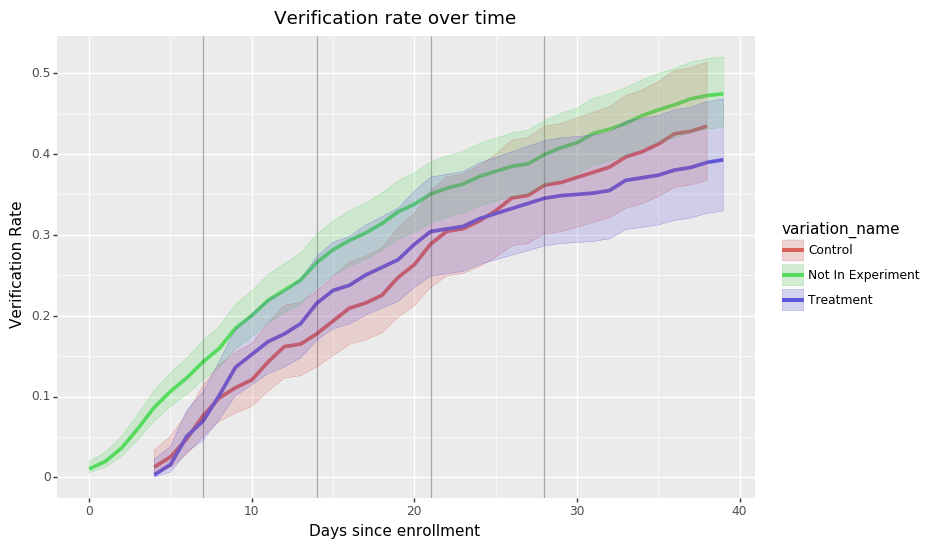

<ggplot: (-9223363302776501146)>

In [25]:
from plotnine import *

df_filter = (all_enrollees.ts < 40)
    

display(
    ggplot(all_enrollees[df_filter].dropna(), aes(
        x='ts',
        y='ps * 100',
        ymin='ps_lo * 100',
        ymax='ps_hi * 100',
        color='variation_name',
        fill='variation_name',
    ))
    + geom_line(size=1.5)
    + geom_vline(xintercept=7, alpha=0.3)
    + geom_vline(xintercept=14, alpha=0.3)
    + geom_vline(xintercept=21, alpha=0.3)
    + geom_vline(xintercept=28, alpha=0.3)
    + geom_ribbon(alpha=0.2, size=0.1)
    + xlab('Days since enrollment')
    + ylab('Verification Rate')
    + theme(figure_size=(9, 6))
    + ggtitle('Verification rate over time')
)

## Only consider users who enrolled in a single course

In [26]:
%%vertica (earliest_enrollment_time, experiment_start_time) -> enrolls_per_user

SELECT
    user_id,
    COUNT(*) AS num_enrollments
FROM production.d_user_course uc
JOIN
    business_intelligence.course_master c
ON uc.course_id = c.course_id
AND c.pacing_type = 'self_paced'
AND (c.content_language IS NULL OR c.content_language LIKE 'en%')
AND c.is_WL = 0
AND GREATEST(c.course_start_date::TIMESTAMPTZ, uc.first_enrollment_time::TIMESTAMPTZ) BETWEEN :earliest_enrollment_time AND :experiment_start_time
GROUP BY 1

In [27]:
enrolls_per_user.groupby('num_enrollments').user_id.count()[:10] / len(enrolls_per_user)

num_enrollments
1     0.731022
2     0.182511
3     0.043176
4     0.017240
5     0.008838
6     0.004851
7     0.003258
8     0.002252
9     0.001522
10    0.001041
Name: user_id, dtype: float64

In [28]:
%%vertica (intervention_date, experiment_id, earliest_enrollment_time) -> engagement_oc

-- This should return one record per user enrollment per week
SELECT
    ee.user_id,
    ee.course_id,
    ee.group_name,
    week_num.weeks_since_experiment_start,
    cnt_days_in_week,
    COALESCE(act.is_engaged, 0) AS is_engaged,
    COALESCE(act.cnt_engaged_activity, 0) AS cnt_engaged_activity
FROM
(
    SELECT
        user_id,
        course_id,
        MAX(group_name) AS group_name
    FROM
        ret.email_experiment
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT group_name) = 1
) ee

JOIN
(
    SELECT
        user_id
    FROM production.d_user_course uc
    JOIN
        business_intelligence.course_master c
    ON      uc.course_id = c.course_id
        AND c.pacing_type = 'self_paced'
        AND (c.content_language IS NULL OR c.content_language LIKE 'en%')
        AND c.is_WL = 0
        AND GREATEST(c.course_start_date::TIMESTAMPTZ, uc.first_enrollment_time::TIMESTAMPTZ) BETWEEN :earliest_enrollment_time AND :intervention_date
    GROUP BY 1
    HAVING COUNT(*) = 1
) single_enroll ON single_enroll.user_id = ee.user_id

JOIN
(
    -- This table simply returns one row with one integer for each week after the start of the experiment that
    -- represents the number of weeks that have elapsed since the start of the experiment. This will look something
    -- like:
    --    weeks_since_experiment_start
    --    0
    --    1
    --    2
    SELECT
        FLOOR(DATEDIFF('day', :intervention_date, date) / 7) AS weeks_since_experiment_start,
        COUNT(DISTINCT date) AS cnt_days_in_week
    FROM business_intelligence.calendar
    WHERE
        date BETWEEN :intervention_date AND (SELECT MAX(date) FROM production.f_user_activity)
    GROUP BY 1
    -- Only include complete weeks
    HAVING COUNT(DISTINCT date) = 7

-- This join condition will ensure that we get one full copy of our enrollments per week. The first copy will
-- have week_num.weeks_since_experiment_start == 0, the second 1, the third 2 etc.
) AS week_num ON 1=1

-- There is a problem with the BI table that defines engagement, so we go directly to the f_user_activity table.
-- We are careful here to define engagement in the standard way.
LEFT JOIN
(
    SELECT
        user_id,
        course_id,
        FLOOR(DATEDIFF('day', :intervention_date, date) / 7) AS weeks_since_experiment_start,
        CASE WHEN SUM(number_of_activities) > 0 THEN 1 ELSE 0 END AS is_engaged,
        SUM(number_of_activities) AS cnt_engaged_activity
    FROM
        production.f_user_activity
    WHERE
        date >= :intervention_date
        AND activity_type IN ('PLAYED_VIDEO', 'POSTED_FORUM', 'ATTEMPTED_PROBLEM')
    GROUP BY 1, 2, 3
) as act
    ON act.user_id = ee.user_id
    AND act.course_id = ee.course_id
    AND act.weeks_since_experiment_start = week_num.weeks_since_experiment_start

/app/lib/edx_stats.py:124: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


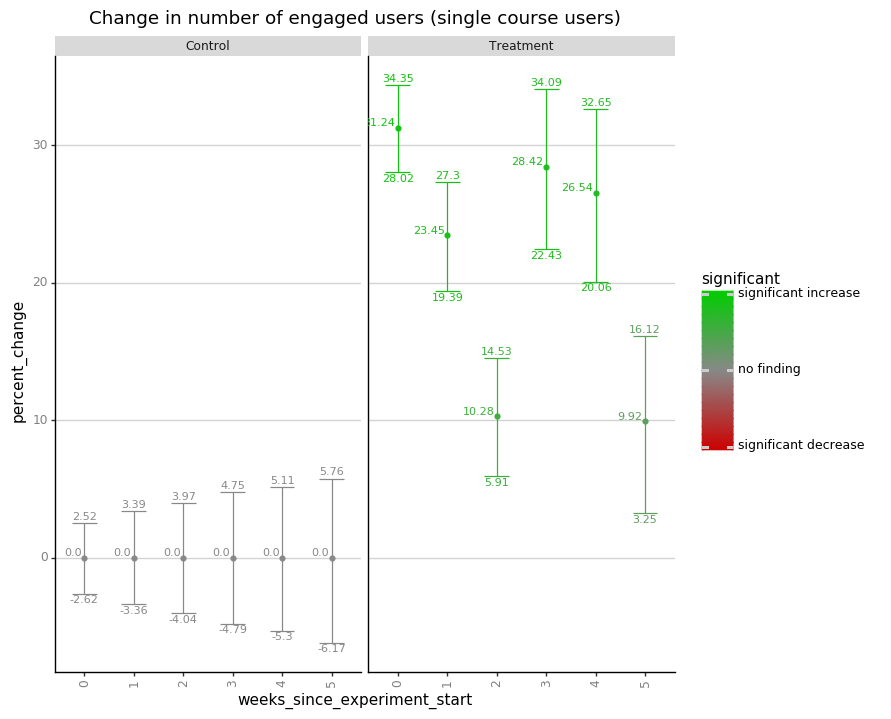

<ggplot: (8734083806945)>

lower_bound  percent_change  \
weeks_since_experiment_start group_name                                
0                            Control       -2.622358        0.000000   
                             Treatment     28.017465       31.238388   
1                            Control       -3.363047        0.000000   
                             Treatment     19.393012       23.448886   
2                            Control       -4.035513        0.000000   
                             Treatment      5.905257       10.277747   
3                            Control       -4.793757        0.000000   
                             Treatment     22.432808       28.423625   
4                            Control       -5.299861        0.000000   
                             Treatment     20.064616       26.543865   
5                            Control       -6.173157        0.000000   
                             Treatment      3.252727        9.917526   

                                         upper_bound  significant  
weeks_since_experiment_start group_name                            
0                            Control        2.523543     0.000000  
                             Treatment     34.353017     0.896892  
1                            Control        3.386141     0.000000  
                             Treatment     27.296151     0.827033  
2                            Control        3.972498     0.000000  
                             Treatment     14.528789     0.574567  
3                            Control        4.751417     0.000000  
                             Treatment     34.086624     0.789231  
4                            Control        5.112327     0.000000  
                             Treatment     32.645654     0.755904  
5                            Control        5.755135     0.000000  
                             Treatment     16.120766     0.327978

In [29]:
compute_confidence_interval(
    engagement_oc,
    variant_col='group_name',
    value_col='is_engaged',
    title='Change in number of engaged users (single course users)',
    group_by='weeks_since_experiment_start'
)

In [30]:
%%vertica (experiment_start_time, transaction_cutoff, experiment_id, earliest_enrollment_time) -> conversions_oc

-- This query should return one record per enrollment.
SELECT
    emailed.user_id,
    emailed.course_id,
    emailed.group_name AS variation_name,
    course.pacing_type,
    purchased.purchase_time,
    CASE WHEN purchased.purchase_time IS NOT NULL THEN 1 ELSE 0 END AS 'verified',
    COALESCE(purchased.gross_bookings, 0)::FLOAT AS gross_bookings
FROM

(
    SELECT
        user_id,
        course_id,
        username,
        MAX(group_name) AS group_name
    FROM
        ret.email_experiment
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2, 3
    HAVING COUNT(DISTINCT group_name) = 1
) emailed

JOIN
(
    SELECT
        user_id
    FROM production.d_user_course uc
    JOIN
        business_intelligence.course_master c
    ON      uc.course_id = c.course_id
        AND c.pacing_type = 'self_paced'
        AND (c.content_language IS NULL OR c.content_language LIKE 'en%')
        AND c.is_WL = 0
        AND GREATEST(c.course_start_date::TIMESTAMPTZ, uc.first_enrollment_time::TIMESTAMPTZ) BETWEEN :earliest_enrollment_time AND :experiment_start_time
    GROUP BY 1
    HAVING COUNT(*) = 1
) single_enroll ON single_enroll.user_id = emailed.user_id

-- Need to join with d_course to get the pacing_type for the course
JOIN production.d_course course ON course.course_id = emailed.course_id

-- Now join with our finance table to find all sales and refunds for this user that are *after* the first exposure
LEFT JOIN
(
    -- This gathers all transactions associated with an enrollment and pins them to the first transaction time.
    -- This should return one record per enrollment.
    SELECT
        f.order_username AS username,
        f.order_course_id AS course_id,
        MIN(f.order_timestamp)::TIMESTAMPTZ AS purchase_time,
        SUM(CASE WHEN f.transaction_type = 'sale' THEN f.transaction_amount_per_item ELSE 0 END) AS gross_bookings
    FROM
        finance.f_orderitem_transactions f
    WHERE
        f.transaction_type IS NOT NULL
        AND f.order_username IS NOT NULL
        AND f.partner_short_code = 'edx'
    GROUP BY
        1, 2
) AS purchased
    ON  emailed.username = purchased.username
    AND emailed.course_id = purchased.course_id
    AND purchased.purchase_time BETWEEN :experiment_start_time AND :transaction_cutoff

In [31]:
totals = conversions_oc.groupby('variation_name').verified.count()
converted = conversions_oc.groupby('variation_name').verified.sum()

print(totals)
print(converted)
converted / totals

variation_name
Control      23574
Treatment    23749
Name: verified, dtype: int64
variation_name
Control      102
Treatment    104
Name: verified, dtype: int64


variation_name
Control      0.004327
Treatment    0.004379
Name: verified, dtype: float64

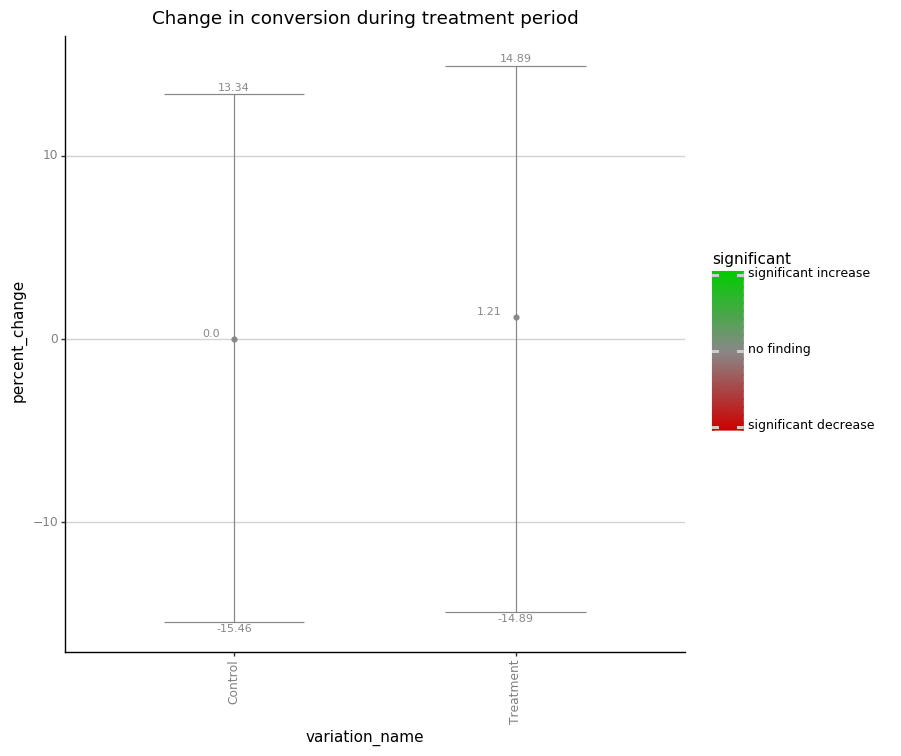

<ggplot: (8734058306431)>

,lower_bound,percent_change,upper_bound,significant
variation_name,,,,
Control,-15.463918,0.000000,13.341207,0
Treatment,-14.892043,1.209463,14.886895,0


In [32]:
compute_confidence_interval(
    conversions_oc,
    variant_col='variation_name',
    value_col='verified',
    title='Change in conversion during treatment period'
)

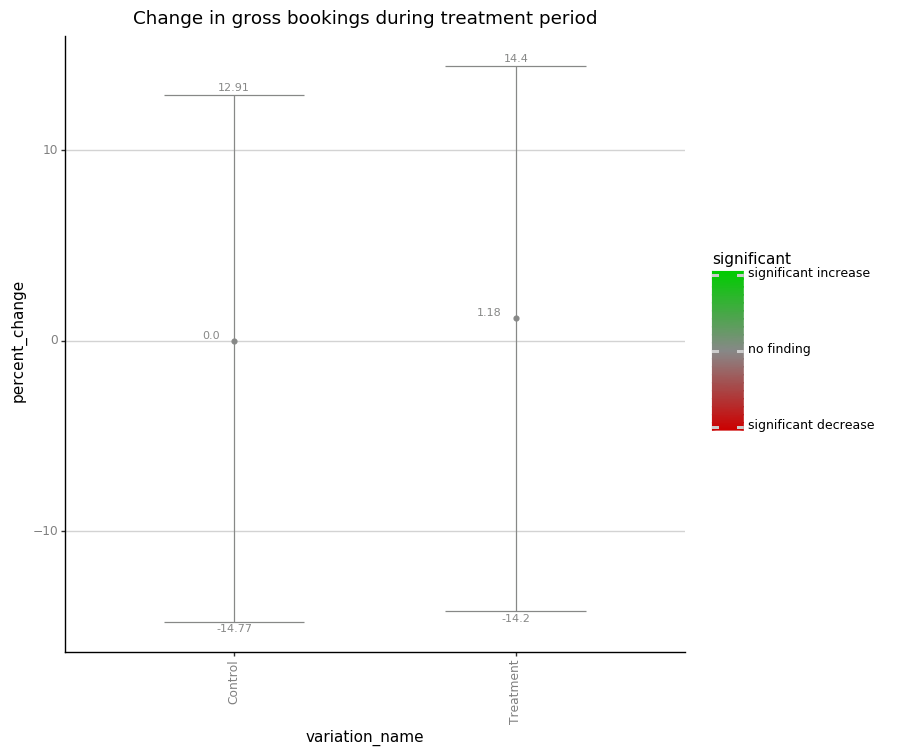

<ggplot: (8734074334756)>

,lower_bound,percent_change,upper_bound,significant
variation_name,,,,
Control,-14.772127,0.000000,12.907696,0
Treatment,-14.203635,1.179953,14.400996,0


In [33]:
compute_confidence_interval(
    conversions,
    variant_col='variation_name',
    value_col='gross_bookings',
    title='Change in gross bookings during treatment period'
)

In [34]:
%%vertica (experiment_start_time, experiment_id, earliest_enrollment_time) -> audit_duration_counts_oc

SELECT
    CASE
        WHEN exp.variation_name IS NOT NULL THEN exp.variation_name
        ELSE 'Not In Experiment'
    END AS variation_name,
    CASE
        WHEN duc.first_verified_enrollment_time IS NULL THEN DATEDIFF('day', duc.first_enrollment_time, NOW())
        ELSE DATEDIFF('day', duc.first_enrollment_time, duc.first_verified_enrollment_time)
    END AS duration,
    duc.first_verified_enrollment_time IS NOT NULL AS verified,
    COUNT(*) AS cnt_users
FROM
    production.d_user_course duc
LEFT JOIN
(
    SELECT
        user_id,
        course_id,
        MAX(group_name) AS variation_name
    FROM
        ret.email_experiment
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT group_name) = 1
) exp ON exp.user_id = duc.user_id AND exp.course_id = duc.course_id
LEFT JOIN
(
    SELECT
        user_id
    FROM production.d_user_course uc
    JOIN
        business_intelligence.course_master c
    ON      uc.course_id = c.course_id
        AND c.pacing_type = 'self_paced'
        AND (c.content_language IS NULL OR c.content_language LIKE 'en%')
        AND c.is_WL = 0
        AND GREATEST(c.course_start_date::TIMESTAMPTZ, uc.first_enrollment_time::TIMESTAMPTZ) BETWEEN :earliest_enrollment_time AND :experiment_start_time
    GROUP BY 1
    HAVING COUNT(*) = 1
) single_enroll ON single_enroll.user_id = exp.user_id
JOIN 
    business_intelligence.course_master AS c ON c.course_id = duc.course_id
WHERE
    -- only include enrollments that occurred before the verification deadline
    duc.first_enrollment_time <= c.course_verification_end_date
    
    -- these are the conditions for courses being included in the experiment
    AND c.pacing_type = 'self_paced'
    AND (c.content_language IS NULL OR c.content_language LIKE 'en%')
    AND c.is_WL = 0
    
    -- compare against a baseline that matches our selection criteria for the experiment: content availability date
    -- within one week from the start of the experiment
    AND GREATEST(duc.first_enrollment_time, c.course_start_date) BETWEEN :earliest_enrollment_time AND :experiment_start_time

    -- only look at verified upgrades after the start of the experiment
    AND (
        duc.first_verified_enrollment_time >= :experiment_start_time
        OR
        duc.first_verified_enrollment_time IS NULL
    )
    
    AND (
        exp.variation_name IS NULL
        OR
        single_enroll.user_id IS NOT NULL
    )

GROUP BY 1, 2, 3
ORDER BY 1, 2, 3

In [35]:
import pandas as pd
from lifelines import KaplanMeierFitter

plot_num = 0
all_enrollees_oc = pd.DataFrame(columns=['ts', 'ps', 'ps_hi', 'ps_lo', 'variation_name'])
        
kmf = KaplanMeierFitter()

for key, group in audit_duration_counts_oc.groupby(
    ['variation_name']
):
    variation_name = key

    exploded_group = explode_dataframe(group)
    kmf.fit(exploded_group.duration, event_observed=exploded_group.verified)
    del exploded_group

    ts = kmf.survival_function_.index.values
    ps = 1.0 - kmf.survival_function_['KM_estimate'].values
    ps_hi = 1.0 - kmf.confidence_interval_['KM_estimate_lower_0.95'].values
    ps_lo = 1.0 - kmf.confidence_interval_['KM_estimate_upper_0.95'].values

    all_enrollees_oc = all_enrollees_oc.append(pd.DataFrame({
        'ts': ts,
        'ps': ps,
        'ps_hi': ps_hi,
        'ps_lo': ps_lo,
        'variation_name': variation_name,
    }, columns=all_enrollees_oc.columns))

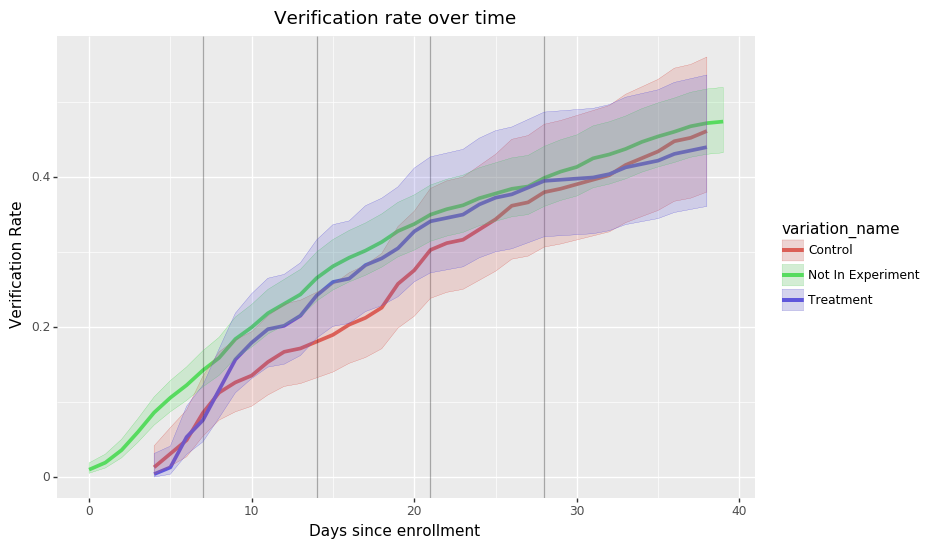

<ggplot: (8734056083923)>

In [36]:
from plotnine import *

df_filter = (all_enrollees_oc.ts < 40)
    

display(
    ggplot(all_enrollees_oc[df_filter].dropna(), aes(
        x='ts',
        y='ps * 100',
        ymin='ps_lo * 100',
        ymax='ps_hi * 100',
        color='variation_name',
        fill='variation_name',
    ))
    + geom_line(size=1.5)
    + geom_vline(xintercept=7, alpha=0.3)
    + geom_vline(xintercept=14, alpha=0.3)
    + geom_vline(xintercept=21, alpha=0.3)
    + geom_vline(xintercept=28, alpha=0.3)
    + geom_ribbon(alpha=0.2, size=0.1)
    + xlab('Days since enrollment')
    + ylab('Verification Rate')
    + theme(figure_size=(9, 6))
    + ggtitle('Verification rate over time')
)